# Data Prep & Modeling
## Filtering

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

marte_raw = pd.read_csv('marte_vs_nlwest_19_22.csv',
                        usecols=['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'pitcher', 'zone', 'des', 'p_throws', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'iso_value', 'launch_speed_angle', 'pitch_name', 'spin_axis'])

# rename the primary response variable
marte_raw.rename(columns={'estimated_woba_using_speedangle': 'xwOBA'}, inplace=True)
print(f"data-set shape prior to filtering: {marte_raw.shape}")

# filter sacrifice events; if woba_denom is NaN, then sacrifice event
marte_raw.dropna(axis='rows', subset=['woba_denom'], how='any', inplace=True)
print(f"data-set shape after to filtering sac hits: {marte_raw.shape}")

# filter missing observation data
marte_raw.dropna(axis='rows', subset=['release_spin_rate', 'spin_axis'], how='any', inplace=True)
print(f"data-set shape after to filtering missing spin observations: {marte_raw.shape}")

data-set shape prior to filtering: (867, 30)
data-set shape after to filtering sac hits: (865, 30)
data-set shape after to filtering missing spin observations: (859, 30)


- release_speed
    - Pitch velocities from 2008-16 are via Pitch F/X, and adjusted to roughly out-of-hand release point. All velocities from 2017 and beyond are Statcast, which are reported out-of-hand.
- release_pos_x
    - horizontal Release Position of the ball measured in feet from the catcher's perspective.
- release_pos_z
    - Vertical Release Position of the ball measured in feet from the catcher's perspective.
- plate_x
    - Horizontal position of the ball when it crosses home plate from the catcher's perspective.
- plate_z
    - Vertical position of the ball when it crosses home plate from the catcher's perspective.
- pitcher
    - MLB Player Id tied to the play event.
- zone
    - Zone location of the ball when it crosses the plate from the catcher's perspective.
- pfx_x
    - Horizontal movement in feet from the catcher's perspective.
- pfx_z
    - Vertical movement in feet from the catcher's perpsective.
- effective_speed
    - Derived speed based on the the extension of the pitcher's release.
- release_spin
    - Spin rate of pitch tracked by Statcast.
- spin_axis
    - The Spin Axis in the 2D X-Z plane in degrees from 0 to 360, such that 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball

## Filtering ext., Computed Features, NaN Conversions

In [4]:
import numpy as np
import math

# filter raw set with proposed model metrics
marte_vs = marte_raw.drop(columns=['game_date', 'release_pos_x', 'release_pos_z', 'des', 'bb_type', 'balls', 'strikes', 'hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_extension', 'woba_denom', 'iso_value', 'launch_speed_angle', 'pitch_name'])
print(f"new data-set shape after to filtering for proper metrics: {marte_vs.shape}")

# vectorize the horizontal & vertical movement using pythagorean theorem
marte_vs['pfx_v'] = np.sqrt(marte_vs.pfx_x ** 2 + marte_vs.pfx_z ** 2)

print(f"number of NaN xwOBA PAs prior to conversion: {marte_vs.xwOBA.isnull().sum()}")

# convert xwOBA stat to 0.0 for strikeouts
# if the xwOBA stat is NaN & a strikeout, then need to use the woba_value

marte_vs['xwOBA'] = marte_vs.apply(lambda x: x.woba_value if (math.isnan(x.xwOBA) and x.woba_value == 0.0) else x.xwOBA, axis=1)

# filter out walks, dropped 54 walks
marte_vs.dropna(axis='rows', subset=['xwOBA'], how='any', inplace=True)
print(f"data-set shape after to filtering walks: {marte_vs.shape}")

# reorder columns for logical readability
marte_vs = marte_vs.reindex(columns=['xwOBA', 'woba_value','game_year', 'pitcher', 'p_throws', 'pitch_type', 'release_speed', 'release_spin_rate', 'spin_axis', 'zone', 'pfx_x', 'pfx_z', 'pfx_v'])

print(marte_vs.head())

new data-set shape after to filtering for proper metrics: (859, 12)
number of NaN xwOBA PAs prior to conversion: 184
data-set shape after to filtering walks: (805, 13)
   xwOBA  woba_value  game_year  pitcher p_throws pitch_type  release_speed  \
0  0.709         0.9       2022   596001        R         SI           92.9   
1  0.262         0.0       2022   596001        R         SI           92.6   
2  0.231         0.0       2022   596001        R         SI           93.0   
3  0.117         0.0       2022   518397        L         SI           93.3   
4  0.438         0.0       2022   502171        R         SI           94.1   

   release_spin_rate  spin_axis  zone  pfx_x  pfx_z     pfx_v  
0             2303.0      211.0     5  -1.15   0.68  1.336001  
1             2316.0      204.0     9  -1.05   0.80  1.320038  
2             2245.0      219.0     8  -1.13   0.79  1.378768  
3             2189.0      135.0     8   1.19   0.28  1.222497  
4             2126.0      221.0     4

## Transformations
### Dummies
A common mistake is to apply transformations to the entire data before splitting into training and test sets. This will bias the model evaluation because information would have leaked from the test set to the training set.

In [5]:
marte_vs_trx = pd.get_dummies(data=marte_vs, columns=['pitch_type', 'zone'])
marte_vs_trx = pd.get_dummies(data=marte_vs_trx, columns=['p_throws'], drop_first=True)
marte_vs_trx.head()

,xwOBA,woba_value,game_year,pitcher,release_speed,release_spin_rate,spin_axis,pfx_x,pfx_z,pfx_v,...,zone_5,zone_6,zone_7,zone_8,zone_9,zone_11,zone_12,zone_13,zone_14,p_throws_R
0,0.709,0.9,2022,596001,92.9,2303.0,211.0,-1.15,0.68,1.336001,...,1,0,0,0,0,0,0,0,0,1
1,0.262,0.0,2022,596001,92.6,2316.0,204.0,-1.05,0.80,1.320038,...,0,0,0,0,1,0,0,0,0,1
2,0.231,0.0,2022,596001,93.0,2245.0,219.0,-1.13,0.79,1.378768,...,0,0,0,1,0,0,0,0,0,1
3,0.117,0.0,2022,518397,93.3,2189.0,135.0,1.19,0.28,1.222497,...,0,0,0,1,0,0,0,0,0,0
4,0.438,0.0,2022,502171,94.1,2126.0,221.0,-1.34,0.45,1.413542,...,0,0,0,0,0,0,0,0,0,1


### Feature and output transformations

In [6]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

X = marte_vs_trx.drop(columns=['xwOBA', 'game_year', 'pitcher'])  # remove response var and extra features
y = marte_vs.xwOBA
# split data into training and testing sets

X = sm.add_constant(X)   # only needed for sm (not smf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1642)

print('Train set shape\n', X_train.shape, y_train.shape)
print('Test set shape\n', X_test.shape, y_test.shape)
print('---')

# transform numerical data
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

num_feats = ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_v', 'pfx_x', 'pfx_z']
# used for positive values
pt = PowerTransformer()
# get a transformed series of numerical features
X_train_trx = pt.fit_transform(X_train[num_feats])
# overwrite raw numerical data
X_train[num_feats] = X_train_trx

# transform the test set with the trained lambdas
X_test_trx = pt.transform(X_test[num_feats])
# overwrite raw numerical dataframe
X_test[num_feats] = X_test_trx
############################
# # normalize output
mms = MinMaxScaler().fit(y_train.to_numpy().reshape(-1, 1))
y_train_trx = pd.Series(map(lambda x: x[0], mms.transform(y_train.to_numpy().reshape(-1, 1))), index=y_train.index)
# normalize on the test output, converted to a pandas.Series with the original indicies
y_test_trx = pd.Series(map(lambda x: x[0], mms.transform(y_test.to_numpy().reshape(-1, 1))), index=y_test.index)

# drop woba_value from feature after use in normalizing response
X_train.drop(columns=['woba_value'], inplace=True)
X_test.drop(columns=['woba_value'], inplace=True)

print('Train trx set shape\n', X_train_trx.shape, y_train_trx.shape)
print('Test trx set shape\n', X_test_trx.shape, y_test_trx.shape)
print('---')

Train set shape
 (523, 31) (523,)
Test set shape
 (282, 31) (282,)
---
Train trx set shape
 (523, 6) (523,)
Test trx set shape
 (282, 6) (282,)
---


## Modeling
### Naive Model
*Note: did not transform the output for the naive model.

In [7]:
# Marte's xwOBA for last 4 seasons ('19-'22) == .348
from sklearn.metrics import *

print(y.mean())
y_same_xwOBA = pd.Series(.348, index=range(0, y_train.size))
# if squared is false then rmse
naive_rmse = mean_squared_error(y_true=y_train, y_pred=y_same_xwOBA, squared=False)
print(f"naive mse: {naive_rmse}")

naive_r2 = r2_score(y_true=y_train, y_pred=y_same_xwOBA)
print(f"naive r2 score: {naive_r2}")

0.3059652173913044
naive mse: 0.38327834366022984
naive r2 score: -0.0034002397516113003


### NN
#### Model 1

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Dropout, BatchNormalization


# normalizer = preprocessing.Normalization()
# normalizer.adapt(np.array(train_features))
X_1 = X_train.release_spin_rate
X_1_test = X_test.release_spin_rate
number_of_inputs = 1  # number of features
model = keras.Sequential([layers.Dense(16, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(16, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

print("Fit model on training data")
history = model.fit(
    X_1,
    y_train_trx,
    batch_size=42,
    epochs=16,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_1_test, y_test_trx),
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_1_test, y_test_trx, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 42 samples")
predictions = model.predict(X_1_test.iloc[:42,])
print("predictions shape:", predictions.shape)

2022-11-30 22:15:35.544176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fit model on training data
Epoch 1/16


2022-11-30 22:15:43.148504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


13/13 [==============================] - 1s 14ms/step - loss: 0.0590 - root_mean_squared_error: 0.2430 - mean_absolute_error: 0.1666 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1776 - val_mean_absolute_error: 0.1250
Epoch 2/16
13/13 [==============================] - 0s 3ms/step - loss: 0.0456 - root_mean_squared_error: 0.2136 - mean_absolute_error: 0.1528 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1662 - val_mean_absolute_error: 0.1271
Epoch 3/16
13/13 [==============================] - 0s 3ms/step - loss: 0.0430 - root_mean_squared_error: 0.2073 - mean_absolute_error: 0.1563 - val_loss: 0.0275 - val_root_mean_squared_error: 0.1657 - val_mean_absolute_error: 0.1312
Epoch 4/16
13/13 [==============================] - 0s 2ms/step - loss: 0.0408 - root_mean_squared_error: 0.2019 - mean_absolute_error: 0.1527 - val_loss: 0.0258 - val_root_mean_squared_error: 0.1608 - val_mean_absolute_error: 0.1263
Epoch 5/16
13/13 [==============================] - 0s 3ms/step - loss: 0.

#### NN2 -- Higher Fidelity Model

In [9]:
X_feats2 = ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_v', 'pitch_type_CH', 'pitch_type_CS', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL', 'zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11', 'zone_12', 'zone_13', 'zone_14', 'p_throws_R']
X_full = X_train[X_feats2]
X_full_test = X_test[X_feats2]
number_of_inputs = X_full.shape[1]  # number of features
model = keras.Sequential([layers.Dense(16, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(16, activation='relu'),
                          layers.Dense(16, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train_trx,
    batch_size=32,
    epochs=16,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test_trx),
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test_trx, batch_size=16)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 42 samples")
predictions = model.predict(X_full_test.iloc[:42,])
print("predictions shape:", predictions.shape)

Fit model on training data
Epoch 1/16
17/17 [==============================] - 1s 10ms/step - loss: 0.1336 - root_mean_squared_error: 0.3656 - mean_absolute_error: 0.2907 - val_loss: 0.0553 - val_root_mean_squared_error: 0.2352 - val_mean_absolute_error: 0.1688
Epoch 2/16
17/17 [==============================] - 0s 2ms/step - loss: 0.0585 - root_mean_squared_error: 0.2419 - mean_absolute_error: 0.1685 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1790 - val_mean_absolute_error: 0.1294
Epoch 3/16
17/17 [==============================] - 0s 2ms/step - loss: 0.0443 - root_mean_squared_error: 0.2104 - mean_absolute_error: 0.1554 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1760 - val_mean_absolute_error: 0.1366
Epoch 4/16
17/17 [==============================] - 0s 2ms/step - loss: 0.0423 - root_mean_squared_error: 0.2056 - mean_absolute_error: 0.1573 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1729 - val_mean_absolute_error: 0.1349
Epoch 5/16
17/17 [==================

In [10]:
from tensorflow.keras import regularizers

X_feats3 = ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_v', 'pitch_type_CH', 'pitch_type_CS', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL']
X_full = X_train[X_feats3]
X_full_test = X_test[X_feats3]
number_of_inputs = X_full.shape[1]  # number of features
model = keras.Sequential([layers.Dense(16, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(), bias_regularizer=regularizers.l1()),
                          layers.Dense(16, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train_trx,
    batch_size=32,
    epochs=4000,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test_trx),
    callbacks=[callback]
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test_trx, batch_size=16)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 42 samples")
predictions = model.predict(X_full_test.iloc[:42,])
print("predictions shape:", predictions.shape)

Fit model on training data
Epoch 1/4000
17/17 [==============================] - 1s 12ms/step - loss: 1.5972 - root_mean_squared_error: 0.2446 - mean_absolute_error: 0.1875 - val_loss: 1.4601 - val_root_mean_squared_error: 0.1753 - val_mean_absolute_error: 0.1310
Epoch 2/4000
17/17 [==============================] - 0s 2ms/step - loss: 1.3881 - root_mean_squared_error: 0.2130 - mean_absolute_error: 0.1602 - val_loss: 1.2687 - val_root_mean_squared_error: 0.1680 - val_mean_absolute_error: 0.1318
Epoch 3/4000
17/17 [==============================] - 0s 2ms/step - loss: 1.2034 - root_mean_squared_error: 0.2059 - mean_absolute_error: 0.1577 - val_loss: 1.0943 - val_root_mean_squared_error: 0.1635 - val_mean_absolute_error: 0.1255
Epoch 4/4000
17/17 [==============================] - 0s 2ms/step - loss: 1.0361 - root_mean_squared_error: 0.2016 - mean_absolute_error: 0.1554 - val_loss: 0.9377 - val_root_mean_squared_error: 0.1633 - val_mean_absolute_error: 0.1299
Epoch 5/4000
17/17 [========

#### Hyper sweep

In [11]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_and_compile_model():
    # create model
    model = keras.Sequential([layers.Dense(16, activation='relu', input_dim=number_of_inputs),
                              layers.Dense(16, activation='relu'),
                              layers.Dense(1, activation='linear') ]) # output layer for regression

    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
    return model

model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)

# define the grid search parameters
batch_size = [8, 16, 32, 64, 128]
epochs = [10, 50, 250, 1250]

param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)

grid_result = grid.fit(X_full, y_train_trx)

/var/folders/nz/57m0v30s0kqdtdm5876x20qw0000gn/T/ipykernel_13941/1658499985.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)
2022-11-30 22:15:49.027869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 22:15:49.027908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with 

6/6 [==============================] - 0s 550us/step


In [12]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

params = grid_result.cv_results_['params']

for mean, param in zip(means, params):
    print("train accuracy %f for: %r" % (mean, param))

Best: -0.255660 using {'batch_size': 8, 'epochs': 10}
train accuracy -0.255660 for: {'batch_size': 8, 'epochs': 10}
train accuracy -0.255660 for: {'batch_size': 8, 'epochs': 50}
train accuracy -0.255660 for: {'batch_size': 8, 'epochs': 250}
train accuracy -0.255662 for: {'batch_size': 8, 'epochs': 1250}
train accuracy -0.255660 for: {'batch_size': 16, 'epochs': 10}
train accuracy -0.255660 for: {'batch_size': 16, 'epochs': 50}
train accuracy -0.255660 for: {'batch_size': 16, 'epochs': 250}
train accuracy -0.255661 for: {'batch_size': 16, 'epochs': 1250}
train accuracy -0.255660 for: {'batch_size': 32, 'epochs': 10}
train accuracy -0.255660 for: {'batch_size': 32, 'epochs': 50}
train accuracy -0.255660 for: {'batch_size': 32, 'epochs': 250}
train accuracy -0.255664 for: {'batch_size': 32, 'epochs': 1250}
train accuracy -0.255680 for: {'batch_size': 64, 'epochs': 10}
train accuracy -0.255660 for: {'batch_size': 64, 'epochs': 50}
train accuracy -0.255660 for: {'batch_size': 64, 'epochs': 

In [13]:
def create_and_compile_model(num_neurons, num_layers):
    # create model
    model = keras.Sequential()
    model.add(Dense(num_neurons, input_dim=number_of_inputs, activation='relu'))

    if num_layers > 0:

        while num_layers > 0:
            model.add(Dense(num_neurons, activation='relu'))
            num_layers=num_layers-1


    model.add(Dense(1, activation='linear')) # output layer for regression

    # Compile model
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

    print(model.summary())
    print('--')

    return model

model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)

# define the grid search parameters
num_neurons_grid = [4, 8, 16]
num_layers_grid = [1, 2, 3, 4]

param_grid = dict(num_neurons=num_neurons_grid, num_layers=num_layers_grid)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)

grid_result = grid.fit(X_full, y_train_trx)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 4)                 56        
                                                                 
 dense_43 (Dense)            (None, 4)                 20        
                                                                 
 dense_44 (Dense)            (None, 1)                 5         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 4)                 56        
                                                                 
 dense_34 (Dense)            (None

/var/folders/nz/57m0v30s0kqdtdm5876x20qw0000gn/T/ipykernel_13941/3761777028.py:25: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)


None
--
1/6 [====>.........................] - ETA: 0sNone
--
6/6 [==============================] - 0s 1ms/step
None
--
6/6 [==============================] - 0s 1ms/step
None
--
6/6 [==============================] - 0s 1ms/step
None
--
6/6 [==============================] - 0s 1ms/step
None
--
1/6 [====>.........................] - ETA: 0sNone
--
6/6 [==============================] - 0s 1ms/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                224       
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 513
Trainable params: 513
Non-tra

In [14]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

params = grid_result.cv_results_['params']

for mean, param in zip(means, params):
    print("train accuracy %f for: %r" % (mean, param))

Best: -0.256242 using {'num_layers': 1, 'num_neurons': 8}
train accuracy -0.256614 for: {'num_layers': 1, 'num_neurons': 4}
train accuracy -0.256242 for: {'num_layers': 1, 'num_neurons': 8}
train accuracy -0.256343 for: {'num_layers': 1, 'num_neurons': 16}
train accuracy -0.256650 for: {'num_layers': 2, 'num_neurons': 4}
train accuracy -0.256452 for: {'num_layers': 2, 'num_neurons': 8}
train accuracy -0.256442 for: {'num_layers': 2, 'num_neurons': 16}
train accuracy -0.256545 for: {'num_layers': 3, 'num_neurons': 4}
train accuracy -0.256562 for: {'num_layers': 3, 'num_neurons': 8}
train accuracy -0.256655 for: {'num_layers': 3, 'num_neurons': 16}
train accuracy -0.256655 for: {'num_layers': 4, 'num_neurons': 4}
train accuracy -0.256655 for: {'num_layers': 4, 'num_neurons': 8}
train accuracy -0.256635 for: {'num_layers': 4, 'num_neurons': 16}


#### Combining Sweep
layers = 4
neurons = 8
batch_size = 8
epochs = 10

In [15]:
model = keras.Sequential([layers.Dense(8, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(8, activation='relu'),
                          layers.Dense(8, activation='relu'),
                          layers.Dense(8, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train_trx,
    batch_size=8,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test_trx),
    callbacks=[callback]
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test_trx, batch_size=16)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 42 samples")
predictions = model.predict(X_full_test.iloc[:42,])
print("predictions shape:", predictions.shape)

Fit model on training data
Epoch 1/10
66/66 [==============================] - 1s 3ms/step - loss: 0.0481 - root_mean_squared_error: 0.2193 - mean_absolute_error: 0.1563 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1705 - val_mean_absolute_error: 0.1286
Epoch 2/10
66/66 [==============================] - 0s 1ms/step - loss: 0.0402 - root_mean_squared_error: 0.2005 - mean_absolute_error: 0.1496 - val_loss: 0.0288 - val_root_mean_squared_error: 0.1698 - val_mean_absolute_error: 0.1364
Epoch 3/10
66/66 [==============================] - 0s 1ms/step - loss: 0.0388 - root_mean_squared_error: 0.1969 - mean_absolute_error: 0.1520 - val_loss: 0.0270 - val_root_mean_squared_error: 0.1642 - val_mean_absolute_error: 0.1306
Epoch 4/10
66/66 [==============================] - 0s 2ms/step - loss: 0.0378 - root_mean_squared_error: 0.1945 - mean_absolute_error: 0.1493 - val_loss: 0.0264 - val_root_mean_squared_error: 0.1626 - val_mean_absolute_error: 0.1299
Epoch 5/10
66/66 [===================

In [16]:
factor = 0.01
model = keras.Sequential([layers.Dense(8, activation='relu', input_dim=number_of_inputs, kernel_regularizer=regularizers.l2(factor)),
                          layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(factor)),
                          layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(factor)),
                          layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(factor)),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train_trx,
    batch_size=8,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test_trx),
    callbacks=[callback]
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test_trx, batch_size=16)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 42 samples")
predictions = model.predict(X_full_test.iloc[:42,])
print("predictions shape:", predictions.shape)

Fit model on training data
Epoch 1/10
66/66 [==============================] - 1s 3ms/step - loss: 0.4158 - root_mean_squared_error: 0.2528 - mean_absolute_error: 0.1880 - val_loss: 0.3477 - val_root_mean_squared_error: 0.1769 - val_mean_absolute_error: 0.1329
Epoch 2/10
66/66 [==============================] - 0s 1ms/step - loss: 0.3317 - root_mean_squared_error: 0.2138 - mean_absolute_error: 0.1596 - val_loss: 0.2834 - val_root_mean_squared_error: 0.1662 - val_mean_absolute_error: 0.1299
Epoch 3/10
66/66 [==============================] - 0s 1ms/step - loss: 0.2727 - root_mean_squared_error: 0.2060 - mean_absolute_error: 0.1539 - val_loss: 0.2313 - val_root_mean_squared_error: 0.1612 - val_mean_absolute_error: 0.1259
Epoch 4/10
66/66 [==============================] - 0s 1ms/step - loss: 0.2250 - root_mean_squared_error: 0.2018 - mean_absolute_error: 0.1516 - val_loss: 0.1899 - val_root_mean_squared_error: 0.1613 - val_mean_absolute_error: 0.1308
Epoch 5/10
66/66 [===================

TW NN

# of inputs = 30
Epoch 1/100


/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


14/14 [==============================] - 0s 11ms/step - loss: 0.2111 - mse: 0.2111 - val_loss: 0.2518 - val_mse: 0.2518
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1883 - mse: 0.1883 - val_loss: 0.2368 - val_mse: 0.2368
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1745 - mse: 0.1745 - val_loss: 0.2259 - val_mse: 0.2259
Epoch 4/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1660 - mse: 0.1660 - val_loss: 0.2204 - val_mse: 0.2204
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1604 - mse: 0.1604 - val_loss: 0.2157 - val_mse: 0.2157
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1562 - mse: 0.1562 - val_loss: 0.2114 - val_mse: 0.2114
Epoch 7/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1527 - mse: 0.1527 - val_loss: 0.2081 - val_mse: 0.2081
Epoch 8/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1504 - mse: 0.1504 

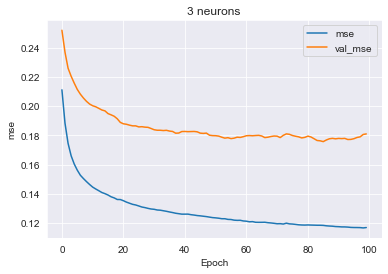

17/17 [==============================] - 0s 665us/step
MAE Train = 0.2698456532573381
MSE Train = 0.1295224435742626
R2  = 0.11531091810087546

9/9 [==============================] - 0s 809us/step
MAE Test = 0.2504495985960284
MSE Test = 0.33248349857739545
R2  = -0.1647074293569255


In [19]:
# Define the loss plot
def plot_loss(history, num_neurons):
  plt.plot(history.history['mse'], label='mse')
  plt.plot(history.history['val_mse'], label='val_mse')
  # plt.ylim([0, y_lim])
  plt.xlabel('Epoch')
  plt.ylabel('mse')
  plt.legend()
  plt.title(f"{num_neurons} neurons")

  plt.grid(True)
  plt.show()
  

import numpy as np
import tensorflow as tf
from   tensorflow import keras
from   tensorflow.keras import layers, regularizers
from   tensorflow.keras.layers.experimental import preprocessing
import matplotlib
import matplotlib.pyplot as plt
from   tensorflow.keras.optimizers import Adam

#setup normalizer
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

number_of_inputs= X_train.shape[1]
print(f"# of inputs = {number_of_inputs}")

num_neurons = 3

# create model
model = keras.Sequential([normalizer,
                          layers.Dense(num_neurons, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(num_neurons, activation='relu'),
                          layers.Dense(1, activation='linear') ])  
  
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics='mse')

history = model.fit(X_train, 
                    y_train, 
                    batch_size=32,
                    epochs=100,
                    validation_split = 0.2)  # Calculate validation results on 20% of the training data
                  
# Isolate and plot training curves 
hist = pd.DataFrame(history.history)
plot_loss(history, num_neurons)

# calculate metrics ---------------
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# train
y_pred = model.predict(X_train)
print(f"MAE Train = {mean_absolute_error(y_train, y_pred)}")
print(f"MSE Train = { mean_squared_error(y_train, y_pred)}")
print(f"R2  = {                 r2_score(y_train, y_pred)}")
print(f"")

# holdout
y_pred = model.predict(X_test)
print(f"MAE Test = {mean_absolute_error(y_test, y_pred)}")
print(f"MSE Test = { mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R2  = {                r2_score(y_test, y_pred)}")

TW NN neurons sweep

Epoch 1/100


/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


14/14 [==============================] - 0s 12ms/step - loss: 0.2348 - mse: 0.2348 - val_loss: 0.2977 - val_mse: 0.2977
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2266 - mse: 0.2266 - val_loss: 0.2881 - val_mse: 0.2881
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2193 - mse: 0.2193 - val_loss: 0.2793 - val_mse: 0.2793
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2123 - mse: 0.2123 - val_loss: 0.2710 - val_mse: 0.2710
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2060 - mse: 0.2060 - val_loss: 0.2634 - val_mse: 0.2634
Epoch 6/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2002 - mse: 0.2002 - val_loss: 0.2561 - val_mse: 0.2561
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1947 - mse: 0.1947 - val_loss: 0.2490 - val_mse: 0.2490
Epoch 8/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1896 - mse: 0.1896 

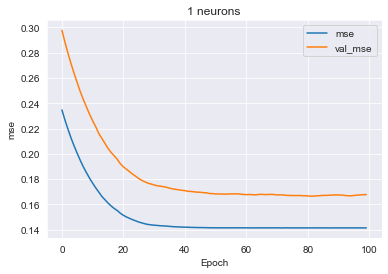

17/17 [==============================] - 0s 622us/step
MAE Train = 0.2942068004977407
MSE Train = 0.14675173417552606
R2  = -0.002371893180132867

9/9 [==============================] - 0s 794us/step
MAE Test = 0.24998706956619912
MSE Test = 0.09633128909467584
R2  = -0.014948546959911102
Epoch 1/100


/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


14/14 [==============================] - 1s 11ms/step - loss: 2.0036 - mse: 2.0036 - val_loss: 2.4262 - val_mse: 2.4262
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 1.7275 - mse: 1.7275 - val_loss: 2.1130 - val_mse: 2.1130
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 1.4979 - mse: 1.4979 - val_loss: 1.8447 - val_mse: 1.8447
Epoch 4/100
14/14 [==============================] - 0s 2ms/step - loss: 1.3038 - mse: 1.3038 - val_loss: 1.6320 - val_mse: 1.6320
Epoch 5/100
14/14 [==============================] - 0s 2ms/step - loss: 1.1559 - mse: 1.1559 - val_loss: 1.4442 - val_mse: 1.4442
Epoch 6/100
14/14 [==============================] - 0s 2ms/step - loss: 1.0167 - mse: 1.0167 - val_loss: 1.2934 - val_mse: 1.2934
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 0.9066 - mse: 0.9066 - val_loss: 1.1601 - val_mse: 1.1601
Epoch 8/100
14/14 [==============================] - 0s 2ms/step - loss: 0.8126 - mse: 0.8126 

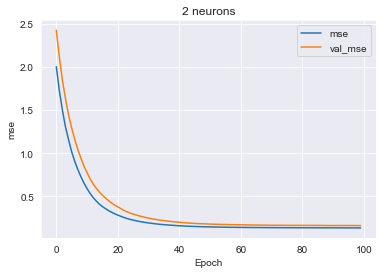

17/17 [==============================] - 0s 667us/step
MAE Train = 0.28305671732603477
MSE Train = 0.14013081991518334
R2  = 0.0428515476126361

9/9 [==============================] - 0s 731us/step
MAE Test = 8127.267294526639
MSE Test = 18625613013.12673
R2  = -196239861850.44284
Epoch 1/100


/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


14/14 [==============================] - 0s 10ms/step - loss: 0.4519 - mse: 0.4519 - val_loss: 0.2753 - val_mse: 0.2753
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 0.3939 - mse: 0.3939 - val_loss: 0.2663 - val_mse: 0.2663
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 0.3513 - mse: 0.3513 - val_loss: 0.2614 - val_mse: 0.2614
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 0.3168 - mse: 0.3168 - val_loss: 0.2585 - val_mse: 0.2585
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2927 - mse: 0.2927 - val_loss: 0.2551 - val_mse: 0.2551
Epoch 6/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2754 - mse: 0.2754 - val_loss: 0.2480 - val_mse: 0.2480
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2618 - mse: 0.2618 - val_loss: 0.2431 - val_mse: 0.2431
Epoch 8/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2501 - mse: 0.2501 

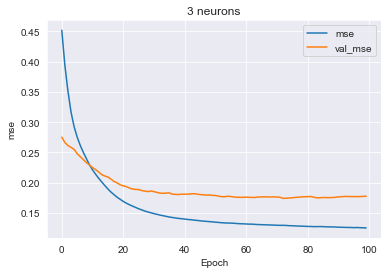

17/17 [==============================] - 0s 709us/step
MAE Train = 0.2799887035823005
MSE Train = 0.13565832968614622
R2  = 0.07340040976609763

9/9 [==============================] - 0s 955us/step
MAE Test = 0.24493450483405
MSE Test = 0.09845256255957206
R2  = -0.037298330100309585
Epoch 1/100


/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


14/14 [==============================] - 0s 11ms/step - loss: 2.5109 - mse: 2.5109 - val_loss: 2.7801 - val_mse: 2.7801
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 1.9392 - mse: 1.9392 - val_loss: 2.1893 - val_mse: 2.1893
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 1.5183 - mse: 1.5183 - val_loss: 1.7646 - val_mse: 1.7646
Epoch 4/100
14/14 [==============================] - 0s 2ms/step - loss: 1.2198 - mse: 1.2198 - val_loss: 1.4453 - val_mse: 1.4453
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 1.0017 - mse: 1.0017 - val_loss: 1.2096 - val_mse: 1.2096
Epoch 6/100
14/14 [==============================] - 0s 2ms/step - loss: 0.8309 - mse: 0.8309 - val_loss: 1.0370 - val_mse: 1.0370
Epoch 7/100
14/14 [==============================] - 0s 2ms/step - loss: 0.7084 - mse: 0.7084 - val_loss: 0.8965 - val_mse: 0.8965
Epoch 8/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6087 - mse: 0.6087 

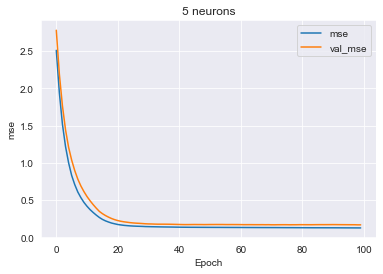

17/17 [==============================] - 0s 654us/step
MAE Train = 0.27541958173636494
MSE Train = 0.13517066748866746
R2  = 0.07673133381183683

9/9 [==============================] - 0s 756us/step
MAE Test = 654.9729329431012
MSE Test = 120881848.21405849
R2  = -1273613768.2303352
Epoch 1/100


/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


14/14 [==============================] - 1s 11ms/step - loss: 0.8516 - mse: 0.8516 - val_loss: 0.5556 - val_mse: 0.5556
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 0.6431 - mse: 0.6431 - val_loss: 0.4785 - val_mse: 0.4785
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 0.5231 - mse: 0.5231 - val_loss: 0.4264 - val_mse: 0.4264
Epoch 4/100
14/14 [==============================] - 0s 2ms/step - loss: 0.4372 - mse: 0.4372 - val_loss: 0.3883 - val_mse: 0.3883
Epoch 5/100
14/14 [==============================] - 0s 2ms/step - loss: 0.3786 - mse: 0.3786 - val_loss: 0.3546 - val_mse: 0.3546
Epoch 6/100
14/14 [==============================] - 0s 2ms/step - loss: 0.3356 - mse: 0.3356 - val_loss: 0.3305 - val_mse: 0.3305
Epoch 7/100
14/14 [==============================] - 0s 2ms/step - loss: 0.3024 - mse: 0.3024 - val_loss: 0.3123 - val_mse: 0.3123
Epoch 8/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2765 - mse: 0.2765 

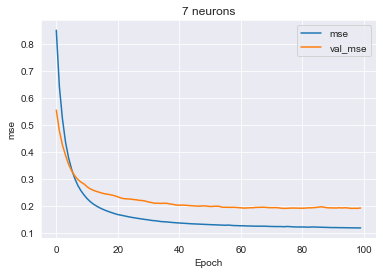

17/17 [==============================] - 0s 641us/step
MAE Train = 0.27148281717505557
MSE Train = 0.13365274093560509
R2  = 0.08709936742486146

9/9 [==============================] - 0s 907us/step
MAE Test = 28.59801805088114
MSE Test = 226604.43178403444
R2  = -2387508.198053424
Epoch 1/100


/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


14/14 [==============================] - 1s 26ms/step - loss: 0.9082 - mse: 0.9082 - val_loss: 0.6572 - val_mse: 0.6572
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 0.6130 - mse: 0.6130 - val_loss: 0.4683 - val_mse: 0.4683
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 0.4515 - mse: 0.4515 - val_loss: 0.3616 - val_mse: 0.3616
Epoch 4/100
14/14 [==============================] - 0s 2ms/step - loss: 0.3591 - mse: 0.3591 - val_loss: 0.3028 - val_mse: 0.3028
Epoch 5/100
14/14 [==============================] - 0s 2ms/step - loss: 0.3037 - mse: 0.3037 - val_loss: 0.2663 - val_mse: 0.2663
Epoch 6/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2692 - mse: 0.2692 - val_loss: 0.2417 - val_mse: 0.2417
Epoch 7/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2459 - mse: 0.2459 - val_loss: 0.2275 - val_mse: 0.2275
Epoch 8/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2289 - mse: 0.2289 

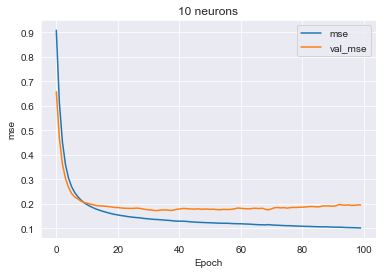

17/17 [==============================] - 0s 645us/step
MAE Train = 0.25338574842376416
MSE Train = 0.11987786793489519
R2  = 0.18118715184260892

9/9 [==============================] - 0s 844us/step
MAE Test = 575.8046162506976
MSE Test = 93414369.47820465
R2  = -984215817.745025
Epoch 1/100


/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


14/14 [==============================] - 0s 10ms/step - loss: 0.9471 - mse: 0.9471 - val_loss: 0.6269 - val_mse: 0.6269
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 0.4693 - mse: 0.4693 - val_loss: 0.4025 - val_mse: 0.4025
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 0.3100 - mse: 0.3100 - val_loss: 0.3326 - val_mse: 0.3326
Epoch 4/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2413 - mse: 0.2413 - val_loss: 0.3006 - val_mse: 0.3006
Epoch 5/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2033 - mse: 0.2033 - val_loss: 0.2833 - val_mse: 0.2833
Epoch 6/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1808 - mse: 0.1808 - val_loss: 0.2721 - val_mse: 0.2721
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1679 - mse: 0.1679 - val_loss: 0.2659 - val_mse: 0.2659
Epoch 8/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1587 - mse: 0.1587 

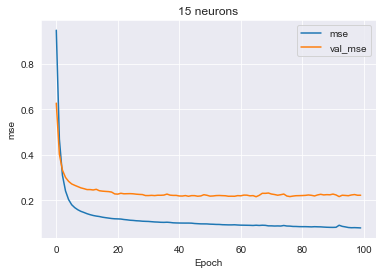

17/17 [==============================] - 0s 629us/step
MAE Train = 0.2337485538850152
MSE Train = 0.10666979902944224
R2  = 0.2714034420172601

9/9 [==============================] - 0s 729us/step
MAE Test = 4934.439489830413
MSE Test = 6865621537.703811
R2  = -72336337124.3202


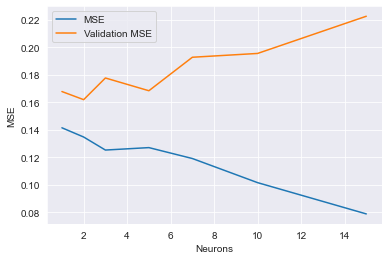

In [20]:
# Define the loss plot
def plot_loss(history):
  plt.plot(history.history['mse'], label='mse')
  plt.plot(history.history['val_mse'], label='val_mse')
  # plt.ylim([0, y_lim])
  plt.xlabel('Epoch')
  plt.ylabel('mse')
  plt.legend()
  plt.title(f"{num_neurons} neurons")

  plt.grid(True)
  plt.show()


from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization

#setup normalizer
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

number_of_inputs = X_train.shape[1]

# sweep neurons
mse_list = []
val_mse_list = []

neurons_to_try = [1, 2, 3, 5, 7, 10, 15]

for num_neurons in neurons_to_try:

  #---- pasted in model
  model = keras.Sequential([normalizer,
                            layers.Dense(num_neurons, activation = 'relu', input_dim = number_of_inputs),
                            layers.Dense(num_neurons, activation = 'relu'),
                            layers.Dense(1, activation = 'linear') ])
    
  model.compile(loss='mse',
                optimizer = tf.keras.optimizers.Adam(0.001),
                metrics = 'mse')

  history = model.fit(X_train, y_train, 
                      epochs = 100,
                      batch_size = 32,
                      validation_split = 0.2)  # Calculate validation results on 20% of the training data
                    
  # Isolate the metric for each epoch.
  hist = pd.DataFrame(history.history)

  #---- end model paste

  # record metrics

  current_mse = hist['mse']
  current_mse = current_mse[len(current_mse)-1]  # last element is the final value
  mse_list.append(current_mse)  

  current_val_mse = hist['val_mse']
  current_val_mse = current_val_mse[len(current_val_mse)-1] #  last element is the final value
  val_mse_list.append(current_val_mse)

  plot_loss(history)

  # calculate metrics ---------------
  from sklearn.metrics import mean_absolute_error
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import r2_score

  # train
  y_pred = model.predict(X_train)
  print(f"MAE Train = {mean_absolute_error(y_train, y_pred)}")
  print(f"MSE Train = { mean_squared_error(y_train, y_pred)}")
  print(f"R2  = {                 r2_score(y_train, y_pred)}")
  print(f"")

  # holdout
  y_pred = model.predict(X_test)
  print(f"MAE Test = {mean_absolute_error(y_test, y_pred)}")
  print(f"MSE Test = { mean_squared_error(y_test, y_pred)}")
  print(f"R2  = {                r2_score(y_test, y_pred)}")

#plot results of sweep
plt.plot(neurons_to_try, mse_list, label='MSE')
plt.plot(neurons_to_try, val_mse_list, label='Validation MSE')

# plt.ylim([1,y_lim])
plt.xlabel('Neurons')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()